In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("/content/preprocessed.csv")

In [3]:
data["Longitude"] = data["Longitude"].fillna(data["Longitude"].median(skipna=True))
data["Latitude"] = data["Latitude"].fillna(data["Latitude"].median(skipna=True))

Algorithm 1
## Random Forest Classifcation

In [4]:
incident_type_cols = [col for col in data.columns if col.startswith('Parent Incident Type_')]

def get_crime_type(row):
    for col in incident_type_cols:
        if row[col]:
            return col.replace('Parent Incident Type_', '')
    return 'Unknown'

data['crime_type'] = data.apply(get_crime_type, axis=1)

data['Incident Datetime'] = pd.to_datetime(data['Incident Datetime (Unix)'], unit='s')
data['Hour'] = data['Incident Datetime'].dt.hour
data['DayOfWeek'] = data['Incident Datetime'].dt.dayofweek
data['Month'] = data['Incident Datetime'].dt.month
data['Year'] = data['Incident Datetime'].dt.year

data = data[data['Year'] >= 2005]
data = data.dropna(subset=['Year'])

X = data.drop(['Unnamed: 0', 'Location', 'crime_type', 'Incident Datetime', 'Incident Datetime (Unix)'] + incident_type_cols, axis=1)

X = pd.get_dummies(X, columns=['Police District'])

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['crime_type'])

smote = SMOTE(random_state=42) ## to avoid imbalance in features
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

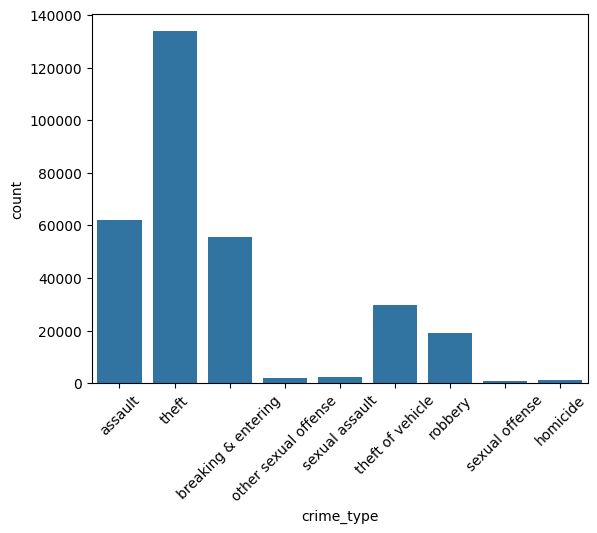

In [5]:
sns.countplot(x='crime_type', data=data)
plt.xticks(rotation=45)
plt.show()

In [6]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.8235223285652002

Classification Report:
                      precision    recall  f1-score   support

             assault       0.65      0.61      0.63     26739
 breaking & entering       0.69      0.66      0.67     26814
            homicide       0.97      1.00      0.98     27008
other sexual offense       0.94      0.99      0.96     26547
             robbery       0.81      0.84      0.82     26544
      sexual assault       0.94      0.99      0.96     26888
      sexual offense       0.97      1.00      0.98     26813
               theft       0.62      0.56      0.59     26829
    theft of vehicle       0.78      0.76      0.77     26653

            accuracy                           0.82    240835
           macro avg       0.82      0.82      0.82    240835
        weighted avg       0.82      0.82      0.82    240835



<Figure size 1500x800 with 0 Axes>

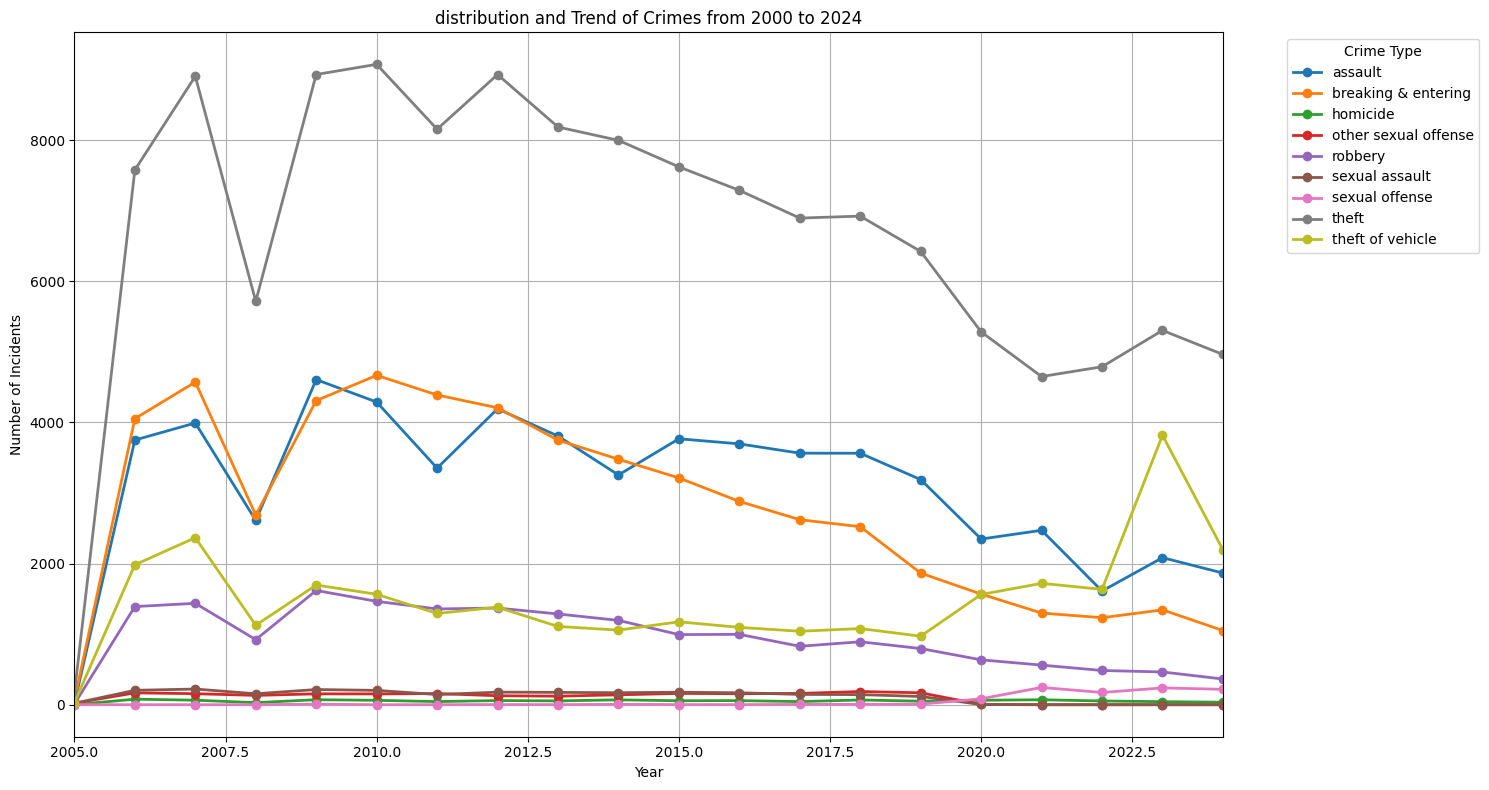

In [7]:
incident_type_cols = [col for col in data.columns if col.startswith('Parent Incident Type_')]

def get_crime_type(row):
    for col in incident_type_cols:
        if row[col]:
            return col.replace('Parent Incident Type_', '')
    return 'Unknown'

data['crime_type'] = data.apply(get_crime_type, axis=1)

data = data[data['Year'] >= 2005]

data = data.dropna(subset=['Year'])

crime_counts = data.groupby(['Year', 'crime_type']).size().reset_index(name='Count')

crime_pivot = crime_counts.pivot(index='Year', columns='crime_type', values='Count').fillna(0)

plt.figure(figsize=(15, 8))
ax = crime_pivot.plot(kind='line', marker='o', figsize=(15, 8), linewidth=2)

plt.title('distribution and Trend of Crimes from 2000 to 2024')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.xlim(2005, data['Year'].max())

plt.tight_layout()
plt.show()

In [8]:
!pip install pyspark

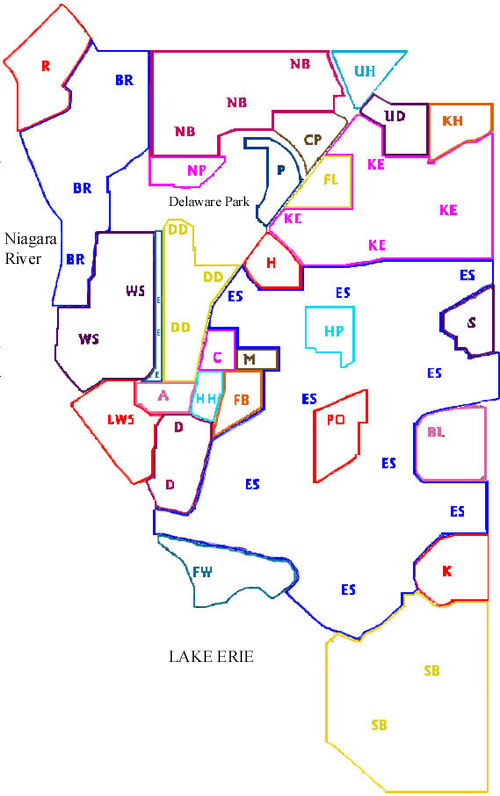

In [9]:
!pip install apache-sedona

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.1 MB/s eta 0:00:00


Algorithm 2
# Map reduce to find crimes by region

In [10]:
neighborhood_boundaries = {
    "A": {"min_lat": 42.920, "max_lat": 42.930, "min_lon": -78.900, "max_lon": -78.890},
    "BL": {"min_lat": 42.880, "max_lat": 42.890, "min_lon": -78.880, "max_lon": -78.870},
    "BR": {"min_lat": 42.880, "max_lat": 42.900, "min_lon": -78.890, "max_lon": -78.880},
    "CP": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.850, "max_lon": -78.840},
    "C": {"min_lat": 42.930, "max_lat": 42.940, "min_lon": -78.890, "max_lon": -78.880},
    "DD": {"min_lat": 42.880, "max_lat": 42.890, "min_lon": -78.800, "max_lon": -78.790},
    "D": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.880, "max_lon": -78.870},
    "ES": {"min_lat": 42.910, "max_lat": 42.920, "min_lon": -78.850, "max_lon": -78.840},
    "E": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.850, "max_lon": -78.840},
    "FL": {"min_lat": 42.930, "max_lat": 42.940, "min_lon": -78.860, "max_lon": -78.850},
    "FW": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.870, "max_lon": -78.860},
    "FB": {"min_lat": 42.930, "max_lat": 42.940, "min_lon": -78.880, "max_lon": -78.870},
    "H": {"min_lat": 42.860, "max_lat": 42.870, "min_lon": -78.860, "max_lon": -78.850},
    "HH": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.850, "max_lon": -78.840},
    "HP": {"min_lat": 42.910, "max_lat": 42.920, "min_lon": -78.860, "max_lon": -78.850},
    "K": {"min_lat": 42.920, "max_lat": 42.930, "min_lon": -78.870, "max_lon": -78.860},
    "KE": {"min_lat": 42.920, "max_lat": 42.930, "min_lon": -78.880, "max_lon": -78.870},
    "KH": {"min_lat": 42.930, "max_lat": 42.940, "min_lon": -78.880, "max_lon": -78.870},
    "LWS": {"min_lat": 42.850, "max_lat": 42.860, "min_lon": -78.890, "max_lon": -78.880},
    "MP": {"min_lat": 42.880, "max_lat": 42.890, "min_lon": -78.850, "max_lon": -78.840},
    "NB": {"min_lat": 42.930, "max_lat": 42.940, "min_lon": -78.890, "max_lon": -78.880},
    "P": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.840, "max_lon": -78.830},
    "PO": {"min_lat": 42.880, "max_lat": 42.890, "min_lon": -78.820, "max_lon": -78.810},
    "R": {"min_lat": 42.920, "max_lat": 42.930, "min_lon": -78.820, "max_lon": -78.810},
    "S": {"min_lat": 42.850, "max_lat": 42.860, "min_lon": -78.820, "max_lon": -78.810},
    "SB": {"min_lat": 42.840, "max_lat": 42.850, "min_lon": -78.800, "max_lon": -78.790},
    "UD": {"min_lat": 42.900, "max_lat": 42.910, "min_lon": -78.800, "max_lon": -78.790},
    "UH": {"min_lat": 42.910, "max_lat": 42.920, "min_lon": -78.800, "max_lon": -78.790},
    "V": {"min_lat": 42.880, "max_lat": 42.890, "min_lon": -78.900, "max_lon": -78.890},
    "WS": {"min_lat": 42.800, "max_lat": 42.810, "min_lon": -78.900, "max_lon": -78.890},
    "W": {"min_lat": 42.820, "max_lat": 42.830, "min_lon": -78.900, "max_lon": -78.890},
    "AK": {"min_lat": 42.950, "max_lat": 42.960, "min_lon": -78.860, "max_lon": -78.850},
    "LS": {"min_lat": 42.830, "max_lat": 42.840, "min_lon": -78.890, "max_lon": -78.880},
    "HS": {"min_lat": 42.940, "max_lat": 42.950, "min_lon": -78.880, "max_lon": -78.870},
    "ECP": {"min_lat": 42.910, "max_lat": 42.920, "min_lon": -78.880, "max_lon": -78.870},
    "WN": {"min_lat": 42.960, "max_lat": 42.970, "min_lon": -78.860, "max_lon": -78.850},
    "OB": {"min_lat": 42.810, "max_lat": 42.820, "min_lon": -78.910, "max_lon": -78.900},
    "SPS": {"min_lat": 42.890, "max_lat": 42.900, "min_lon": -78.870, "max_lon": -78.860},
    "GH": {"min_lat": 42.920, "max_lat": 42.930, "min_lon": -78.810, "max_lon": -78.800},
    "LA": {"min_lat": 42.850, "max_lat": 42.860, "min_lon": -78.880, "max_lon": -78.870},
    "TT": {"min_lat": 42.860, "max_lat": 42.870, "min_lon": -78.850, "max_lon": -78.840},
}

name = {
    "A": "Allentown",
    "BL": "Bailey-Lovejoy",
    "BR": "Black Rock",
    "CP": "Central Park",
    "C": "Cold Springs",
    "DD": "Delaware District",
    "D": "Downtown",
    "ES": "East Side",
    "E": "Elmwood Strip",
    "FL": "Fillmore-Leroy",
    "FW": "First Ward",
    "FB": "Fruit Belt",
    "H": "Hamlin Park",
    "HH": "Hospital Hill",
    "HP": "Humboldt Park",
    "K": "Kaisertown",
    "KE": "Kensington",
    "KH": "Kensington Heights",
    "LWS": "Lower West Side",
    "MP": "Masten Park",
    "NB": "North Buffalo",
    "P": "Parkside",
    "PO": "Polonia",
    "R": "Riverside",
    "S": "Schiller Park",
    "SB": "South Buffalo",
    "UD": "University District",
    "UH": "University Heights",
    "V": "Vernon Triangle",
    "WS": "West Side",
    "W": "Willert Park",
    "AK": "Amherst-Kenmore",
    "LS": "Lower South Side",
    "HS": "Hertel Strip",
    "ECP": "East Central Park",
    "WN": "West North Buffalo",
    "OB": "Outer Buffalo",
    "SPS": "South Parkside",
    "GH": "Grant Heights",
    "LA": "Lafayette",
    "TT": "Theatre District"
}

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [12]:
spark = SparkSession.builder.appName("CrimeCountByRegion").getOrCreate()

# Sample data loading (replace with your actual data path)
data = spark.read.csv('/content/preprocessed.csv', header=True, inferSchema=True)

broadcast_boundaries = spark.sparkContext.broadcast(neighborhood_boundaries)

def assign_region(lat, lon):
    boundaries = broadcast_boundaries.value
    for abbrev, bounds in boundaries.items():
        if bounds['min_lat'] <= lat <= bounds['max_lat'] and bounds['min_lon'] <= lon <= bounds['max_lon']:
            return name[abbrev]
    return 'Unknown'

assign_region_udf = udf(assign_region, StringType())

data_with_region = data.withColumn('Region', assign_region_udf(data['Latitude'], data['Longitude']))

region_counts = data_with_region.groupBy('region').count()
region_counts = region_counts.filter(region_counts.region != 'Unknown')

region_counts.show()

region_counts = region_counts.orderBy('count', ascending=False)

region_counts.coalesce(1).write.csv('crime_counts_by_region', header=True, mode='overwrite')


if region_counts.count() > 0:
    region_counts_df = region_counts.toPandas()
else:
    print("No data available in region_counts.")

+-------------------+-----+
|             region|count|
+-------------------+-----+
|     South Parkside| 2958|
|          Allentown| 4802|
|        Hamlin Park|  683|
|        Masten Park| 2187|
|University District|  282|
|     Bailey-Lovejoy|10500|
|         Kensington| 3947|
|         Fruit Belt| 1037|
|  Delaware District|  303|
|  East Central Park| 4303|
|   Theatre District|  685|
|          Lafayette|   27|
|      Humboldt Park| 4333|
| University Heights| 1003|
|       Central Park| 2982|
|      Grant Heights| 5727|
|      Schiller Park| 3641|
|          East Side| 4506|
|           Downtown| 6768|
|         Kaisertown| 1740|
+-------------------+-----+
only showing top 20 rows



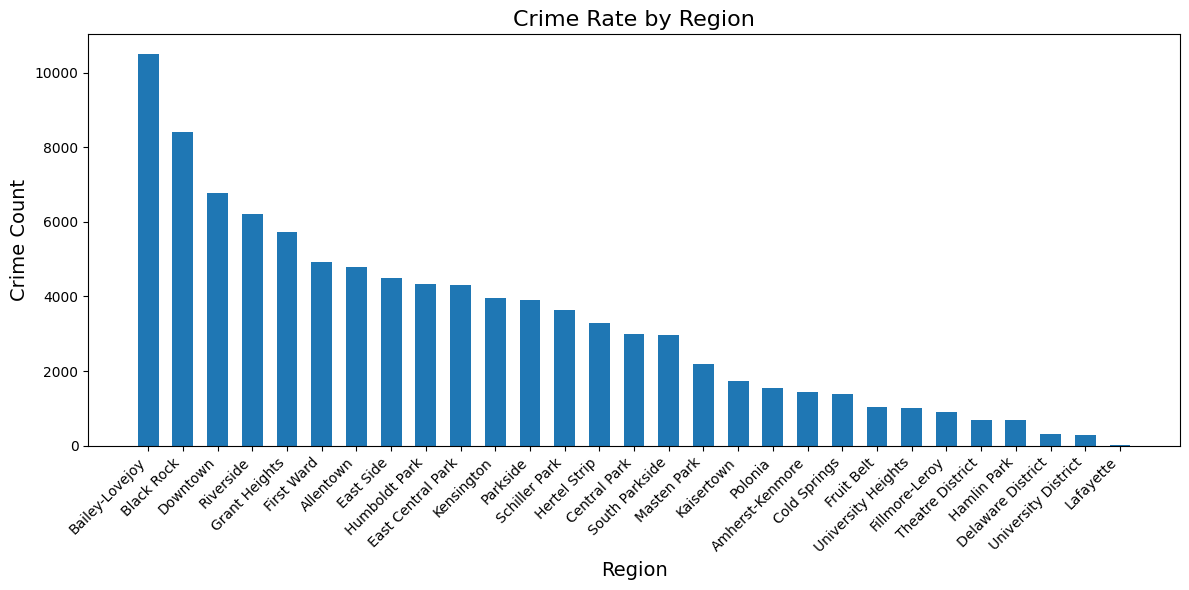

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(region_counts_df['region'], region_counts_df['count'], width=0.6)

# Adding labels and title
plt.xlabel('Region', fontsize=14)
plt.ylabel('Crime Count', fontsize=14)
plt.title('Crime Rate by Region', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

Algorithm 3
#Time series : A time series is a sequence of data points collected, recorded, or measured at successive, evenly-spaced time intervals.

In [14]:
data = pd.read_csv("/content/preprocessed.csv")

In [15]:
data['Incident Datetime'] = pd.to_datetime(data['Incident Datetime (Unix)'], unit='s')

data_filtered = data[data['Incident Datetime'].dt.year >= 2005]

data_filtered = data_filtered.sort_values('Incident Datetime').set_index('Incident Datetime')

data_filtered.head()

,Unnamed: 0,Location,Census Block Group,Census Block,Police District,Incident Datetime (Unix),census avg,case_solved,Parent Incident Type_assault,Parent Incident Type_breaking & entering,Parent Incident Type_homicide,Parent Incident Type_other sexual offense,Parent Incident Type_robbery,Parent Incident Type_sexual assault,Parent Incident Type_sexual offense,Parent Incident Type_theft,Parent Incident Type_theft of vehicle,Longitude,Latitude
Incident Datetime,,,,,,,,,,,,,,,,,,,
2005-01-01,62323,POINT (-78.882 42.899),2,2002,B,1104537600,68.010,0,False,True,False,False,False,False,False,False,False,-78.882,42.899
2005-01-01,71947,POINT (-78.878 42.941),2,2004,D,1104537600,54.000,0,False,False,False,False,False,False,False,True,False,-78.878,42.941
2005-01-01,4846,POINT (-78.9 42.955),3,3004,D,1104537600,58.020,0,False,False,False,True,False,False,False,False,False,-78.900,42.955
2005-01-01,33424,POINT (-78.815 42.899),2,2001,C,1104537600,28.005,0,False,False,False,True,False,False,False,False,False,-78.815,42.899
2005-01-01,60709,POINT (-78.863 42.916),1,1017,E,1104537600,168.010,0,False,False,False,False,False,False,False,True,False,-78.863,42.916


<ipython-input-16-6f2f841547bd>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_incidents = data_filtered.resample('M').size()


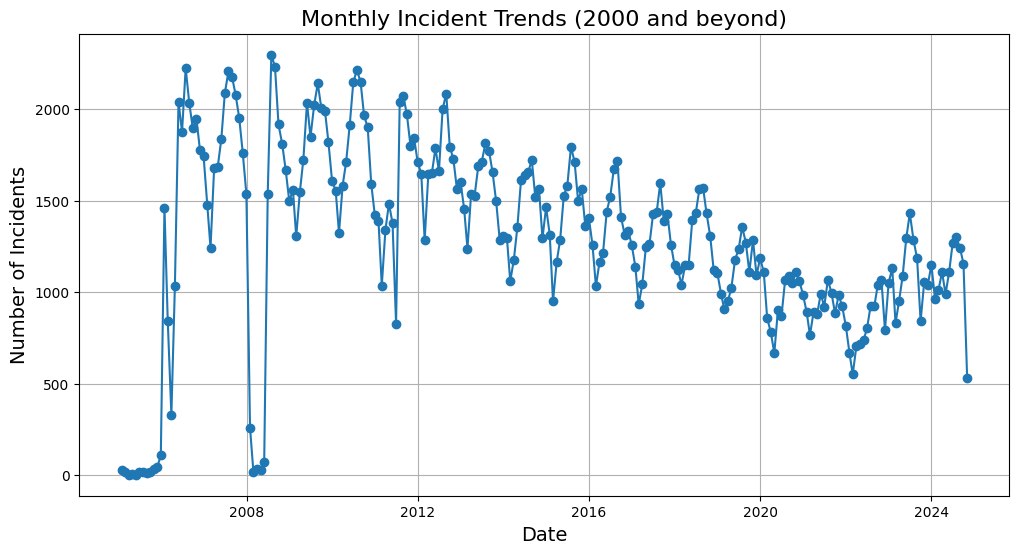

In [16]:
monthly_incidents = data_filtered.resample('M').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_incidents.index, monthly_incidents, marker='o', linestyle='-')
plt.title('Monthly Incident Trends (2000 and beyond)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.grid(True)
plt.show()

<ipython-input-17-caf75c206e79>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_incidents = data_filtered.resample('M').size()
<ipython-input-17-caf75c206e79>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index_10_years = pd.date_range(


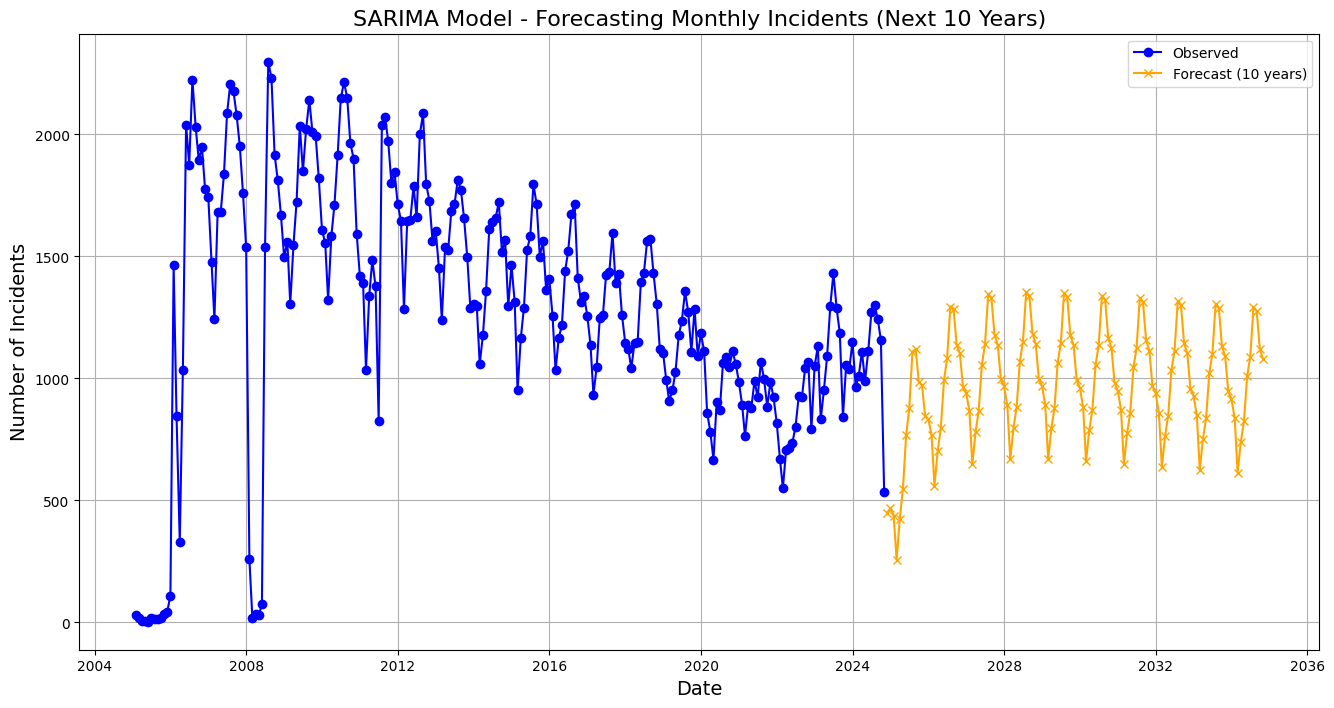

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data['Incident Datetime'] = pd.to_datetime(data['Incident Datetime (Unix)'], unit='s')
data_filtered = data[data['Incident Datetime'].dt.year >= 2005]
data_filtered = data_filtered.set_index('Incident Datetime').sort_index()

monthly_incidents = data_filtered.resample('M').size()

sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

predefined_model = SARIMAX(
    monthly_incidents,
    order=sarima_order,
    seasonal_order=seasonal_order
)
predefined_results = predefined_model.fit(disp=False)

forecast_steps_10_years = 120
sarima_forecast_10_years = predefined_results.get_forecast(steps=forecast_steps_10_years)
forecast_index_10_years = pd.date_range(
    start=monthly_incidents.index[-1] + pd.DateOffset(months=1),
    periods=forecast_steps_10_years,
    freq='M'
)
forecast_values_10_years = sarima_forecast_10_years.predicted_mean

plt.figure(figsize=(16, 8))
plt.plot(monthly_incidents, label='Observed', marker='o', color='blue')
plt.plot(forecast_index_10_years, forecast_values_10_years, label='Forecast (10 years)', color='orange', marker='x')
plt.title('SARIMA Model - Forecasting Monthly Incidents (Next 10 Years)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Algorithm 4
# K Nearest Neighbours

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import folium

In [19]:
# Load data
data = pd.read_csv("/content/preprocessed.csv")

# Explore the data
print(data.head())
print(data.info())

   Unnamed: 0                Location  Census Block Group  Census Block  \
0           0  POINT (-78.889 42.938)                   2          2003   
1           1  POINT (-78.809 42.889)                   4          4001   
2           3  POINT (-78.879 42.954)                   2          2007   
3           4  POINT (-78.879 42.954)                   2          2007   
4           5  POINT (-78.848 42.913)                   3          3009   

  Police District  Incident Datetime (Unix)  census avg  case_solved  \
0               D                1465867200       55.00            1   
1               C                1481605200       23.00            1   
2               D                1416211680       56.00            1   
3               D                1429525320       56.00            1   
4               C                1428634800       33.02            1   

   Parent Incident Type_assault  Parent Incident Type_breaking & entering  \
0                          True        

In [20]:
# Drop the unnamed index column
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

# Check for nulls
print(data.isnull().sum())

Location                                     0
Census Block Group                           0
Census Block                                 0
Police District                              0
Incident Datetime (Unix)                     0
census avg                                   0
case_solved                                  0
Parent Incident Type_assault                 0
Parent Incident Type_breaking & entering     0
Parent Incident Type_homicide                0
Parent Incident Type_other sexual offense    0
Parent Incident Type_robbery                 0
Parent Incident Type_sexual assault          0
Parent Incident Type_sexual offense          0
Parent Incident Type_theft                   0
Parent Incident Type_theft of vehicle        0
Longitude                                    0
Latitude                                     0
dtype: int64


In [21]:
# Encode categorical variables (case_solved, incident types)
encoder = LabelEncoder()
data['case_solved'] = encoder.fit_transform(data['case_solved'])

# One-hot encode incident types (only selected columns with 'Parent Incident Type')
incident_types = [col for col in data.columns if "Parent Incident Type" in col]
data_encoded = pd.get_dummies(data, columns=incident_types, drop_first=True)

print(data_encoded.columns)

Index(['Location', 'Census Block Group', 'Census Block', 'Police District',
       'Incident Datetime (Unix)', 'census avg', 'case_solved', 'Longitude',
       'Latitude', 'Parent Incident Type_assault_True',
       'Parent Incident Type_breaking & entering_True',
       'Parent Incident Type_homicide_True',
       'Parent Incident Type_other sexual offense_True',
       'Parent Incident Type_robbery_True',
       'Parent Incident Type_sexual assault_True',
       'Parent Incident Type_sexual offense_True',
       'Parent Incident Type_theft_True',
       'Parent Incident Type_theft of vehicle_True'],
      dtype='object')


In [22]:
# Normalize numerical data
scaler = StandardScaler()
data[['Longitude', 'Latitude', 'census avg']] = scaler.fit_transform(data[['Longitude', 'Latitude', 'census avg']])

# Select features for KNN
X = data[['Longitude', 'Latitude', 'census avg', 'case_solved']]
y = data_encoded['Parent Incident Type_theft_True']  # Example target: Theft-related crimes

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Fit the KNN model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.70      0.67     34553
        True       0.56      0.49      0.52     26963

    accuracy                           0.61     61516
   macro avg       0.60      0.60      0.60     61516
weighted avg       0.60      0.61      0.60     61516

Confusion Matrix:
[[24275 10278]
 [13794 13169]]


In [24]:
# Fit KMeans to analyze clusters of crimes
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# silhouette score
silhouette_avg = silhouette_score(X, data['Cluster'])
print(f"Silhouette Score for Clustering: {silhouette_avg}")

Silhouette Score for Clustering: 0.4249235318793561


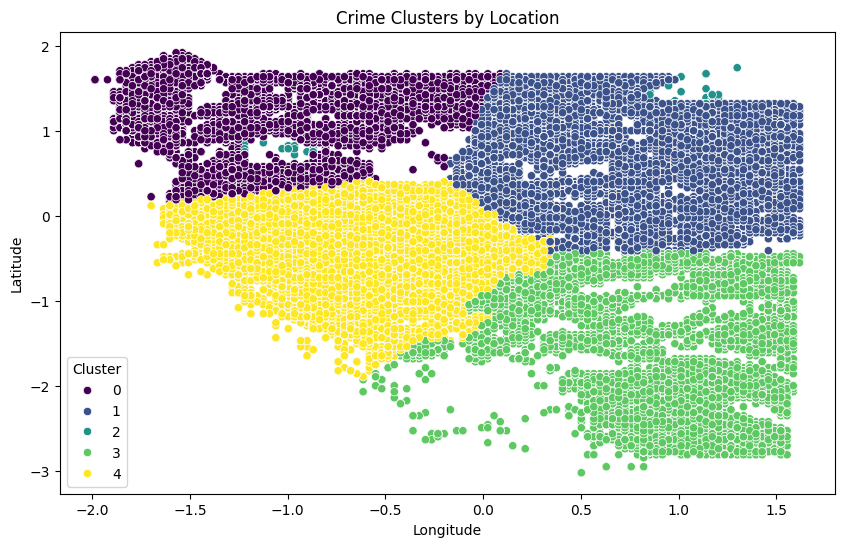

         Parent Incident Type_assault  \
Cluster                                 
0                            0.151399   
1                            0.228253   
2                            0.188356   
3                            0.227694   
4                            0.190186   

         Parent Incident Type_breaking & entering  \
Cluster                                             
0                                        0.172547   
1                                        0.209536   
2                                        0.061644   
3                                        0.193158   
4                                        0.151469   

         Parent Incident Type_homicide  \
Cluster                                  
0                             0.002165   
1                             0.005026   
2                             0.000000   
3                             0.002928   
4                             0.003015   

         Parent Incident Type_other sexual of

In [25]:
# Crime Clusters (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Longitude'], y=data['Latitude'], hue=data['Cluster'], palette='viridis')
plt.title("Crime Clusters by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

cluster_analysis = data.groupby('Cluster')[incident_types].mean()
print(cluster_analysis)

In [26]:
print(data.groupby('Cluster')['census avg'].mean())

Cluster
0     0.004977
1    -0.137306
2    30.823149
3    -0.208527
4     0.165379
Name: census avg, dtype: float64


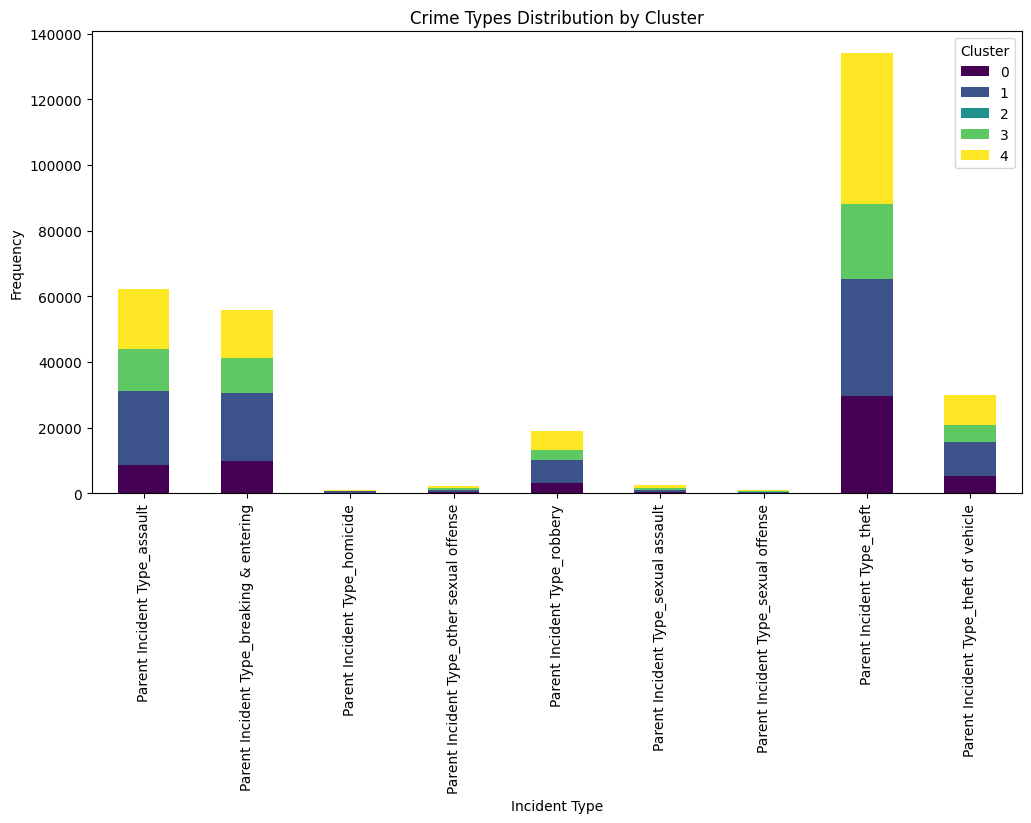

In [27]:
cluster_counts = data.groupby('Cluster')[incident_types].sum().T
cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Crime Types Distribution by Cluster")
plt.xlabel("Incident Type")
plt.ylabel("Frequency")
plt.legend(title="Cluster")
plt.show()


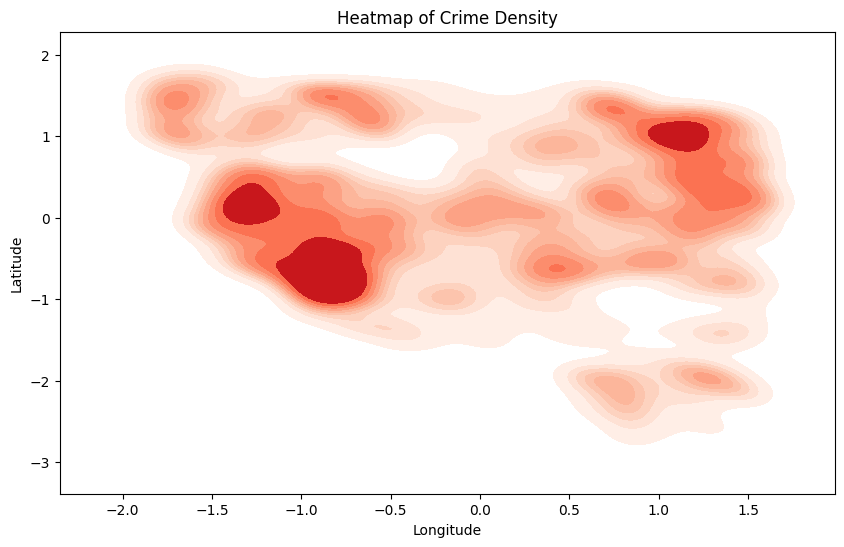

In [28]:
#Heatmap for Crime Density
plt.figure(figsize=(10, 6))
sns.kdeplot(x=data['Longitude'], y=data['Latitude'], cmap="Reds", fill=True)
plt.title("Heatmap of Crime Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

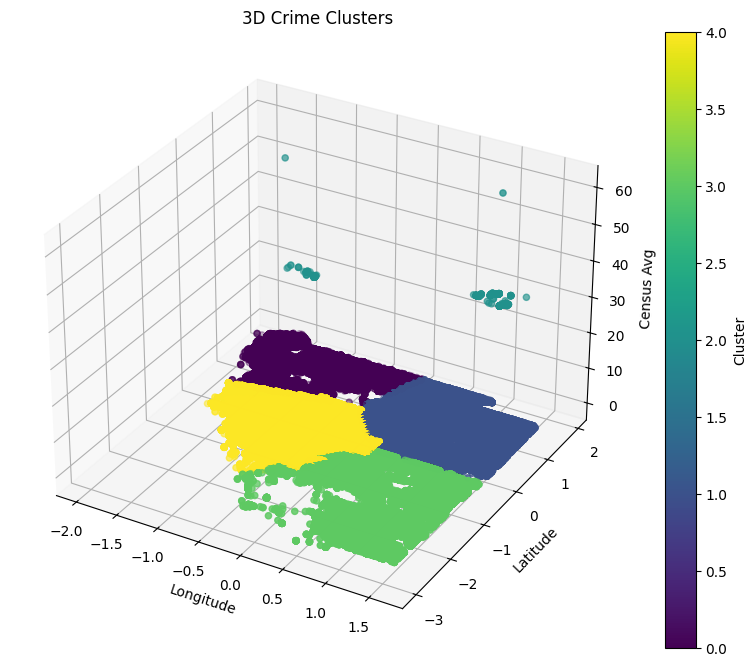

In [29]:
#Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Longitude'], data['Latitude'], data['census avg'], c=data['Cluster'], cmap='viridis')
ax.set_title("3D Crime Clusters")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Census Avg")
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

Algorithm 5
# Logistic Regression


In [31]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [32]:
f_path = "/content/preprocessed.csv"  #loading the dataset
data = pd.read_csv(f_path)

col_to_drop = ['Unnamed: 0', 'Location', 'Longitude', 'Latitude', 'Incident Datetime (Unix)']
cleaned_data = data.drop(columns=col_to_drop, axis=1)

data_encoded = pd.get_dummies(cleaned_data, drop_first=True) #converting categorical to 0 and 1 by performing one-hot encoding

X = data_encoded.drop(columns=['case_solved'], axis=1)
y = data_encoded['case_solved']

smote = SMOTE(random_state=42)              #smote was performed to balance column values
X_resampled, y_resampled = smote.fit_resample(X, y)

scal = StandardScaler()
X_resampled = scal.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=50, stratify=y_resampled) #splitting the data in 70 and 30 r

model = LogisticRegression(random_state=50, max_iter=500) #implementing logistic regression
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Solved', 'Solved']))

Classification Report:
              precision    recall  f1-score   support

  Not Solved       0.63      0.89      0.74     91024
      Solved       0.82      0.48      0.60     91024

    accuracy                           0.68    182048
   macro avg       0.72      0.68      0.67    182048
weighted avg       0.72      0.68      0.67    182048



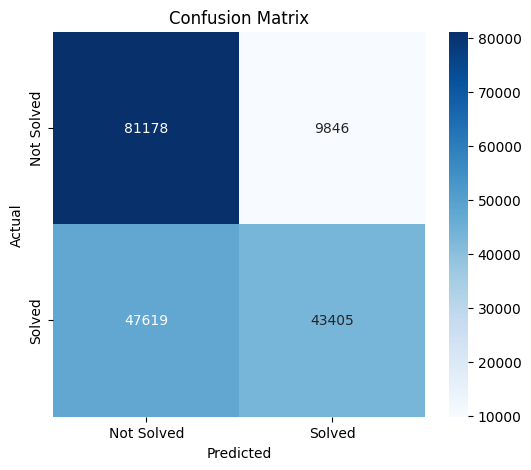

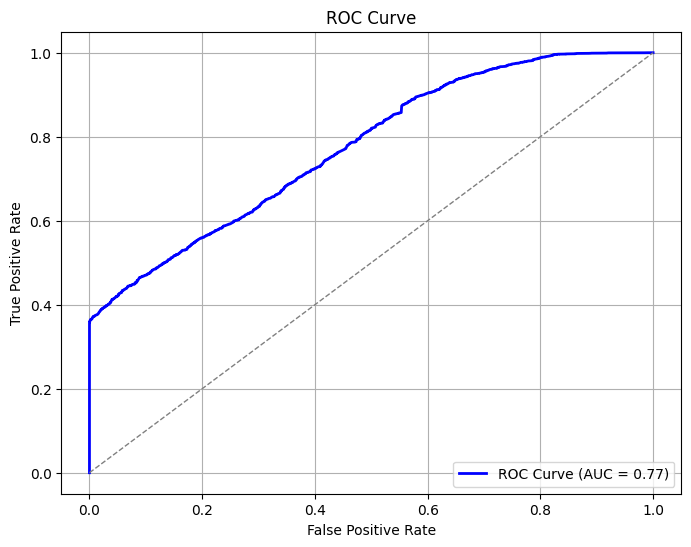

<ipython-input-33-b0da2548fe29>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=f_importance, palette='viridis')


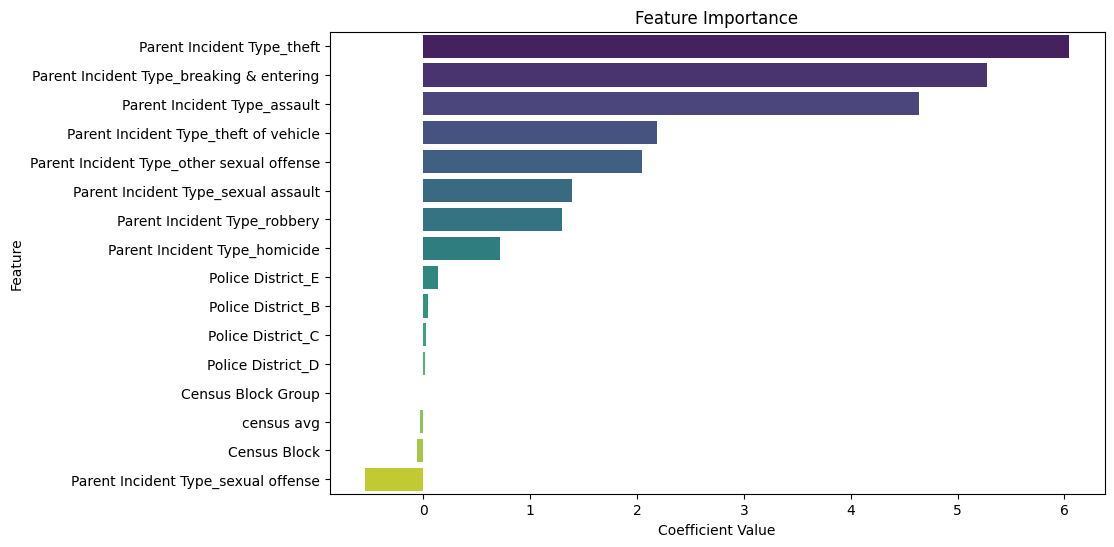

In [33]:
#plot of confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Solved', 'Solved'],
            yticklabels=['Not Solved', 'Solved'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#plot of Roc curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

f_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
f_importance = f_importance.sort_values(by='Importance', ascending=False)

#Feature Importance

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=f_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()